In [ ]:
import pandas as pd

df = pd.read_csv(
    "/content/data.csv",
    encoding="latin1",
    engine="python",     # <-- KEY FIX
    on_bad_lines="skip"  # <-- skip corrupted rows
)

df.head()


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [ ]:
[col for col in df.columns if "NO2" in col or "no2" in col]


['no2']

In [ ]:
x = df["no2"].dropna().values


In [ ]:
import numpy as np

ar = 0.20
br = 1.5

z = x + ar * np.sin(br * x)

# Normalize for GAN stability
z = (z - z.mean()) / z.std()
z = z.reshape(-1, 1)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

z_tensor = torch.tensor(z, dtype=torch.float32)


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
G = Generator()
D = Discriminator()

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.001)
optimizer_D = optim.Adam(D.parameters(), lr=0.001)


In [ ]:
epochs = 1500
batch_size = 128

for epoch in range(epochs):
    idx = torch.randint(0, z_tensor.size(0), (batch_size,))
    real_samples = z_tensor[idx]

    noise = torch.randn(batch_size, 1)
    fake_samples = G(noise)

    # Train Discriminator
    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    loss_D = criterion(D(real_samples), real_labels) + \
             criterion(D(fake_samples.detach()), fake_labels)

    optimizer_D.zero_grad()
    loss_D.backward()
    optimizer_D.step()

    # Train Generator
    loss_G = criterion(D(fake_samples), real_labels)

    optimizer_G.zero_grad()
    loss_G.backward()
    optimizer_G.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")


Epoch 0 | D Loss: 1.3876 | G Loss: 0.7424
Epoch 500 | D Loss: 0.4945 | G Loss: 1.5563
Epoch 1000 | D Loss: 1.1979 | G Loss: 0.8154


In [ ]:
with torch.no_grad():
    noise = torch.randn(2000, 1)
    z_fake = G(noise).numpy().flatten()


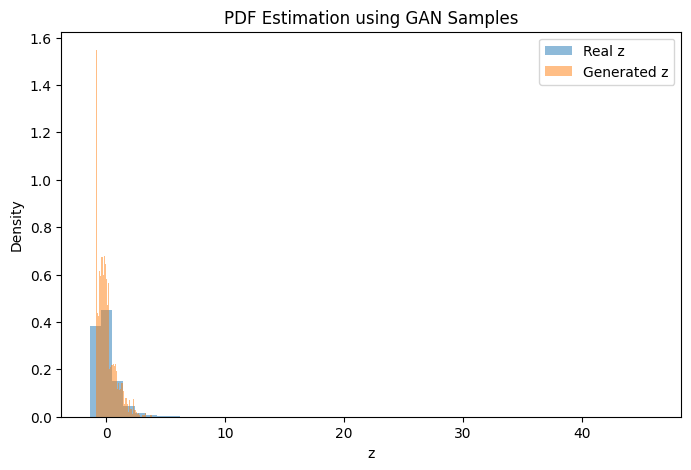

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(z, bins=50, density=True, alpha=0.5, label="Real z")
plt.hist(z_fake, bins=50, density=True, alpha=0.5, label="Generated z")
plt.xlabel("z")
plt.ylabel("Density")
plt.title("PDF Estimation using GAN Samples")
plt.legend()
plt.show()
